In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import tqdm.notebook as tqdm
import numpy as np
from torch.utils import data as D
import os
import sys
dir_path = os.path.dirname(os.path.realpath('__file__'))
sys.path.append('/'.join(dir_path.split('/')[:-1]) + '/src/models')
import regression_2d, data_loader
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from scipy import stats
import seaborn as sns


In [4]:

test_set = data_loader.data_loader(library='LL2',data_path = '../data/')
test_loader = D.DataLoader(test_set, batch_size = 1)
model = regression_2d.regression2d()
state_dict = torch.load('../trained_models/LL1_model.pt', map_location = torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'])
device = torch.device('cuda:1')
model = model.to(device).eval()


In [5]:
def num_of_new_aa(A,B):
    c = 0
    new_AAs = ['K', 'N', 'Q', 'Y',' D', 'E']
    for aa in A:
        if aa in new_AAs:
            c+=1
    for aa in B:
        if aa in new_AAs:
            c+=1
    return c

In [7]:
pred_prob = []
gt_prob = []
result_binned = {x:{'pred_prob':[], 'gt_prob':[]} for x in range(9)}
pbar = tqdm.tqdm(total = len(test_loader))
for data in test_loader:
    A = data[4][0]
    B = data[5][0]
    count = num_of_new_aa(A,B)
    pbar.update()
    pred = model(data[0].unsqueeze(1).cuda(1)).item()
    result_binned[count]['pred_prob'].append(pred)
    result_binned[count]['gt_prob'].append(data[3].item())

  0%|          | 0/5565 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


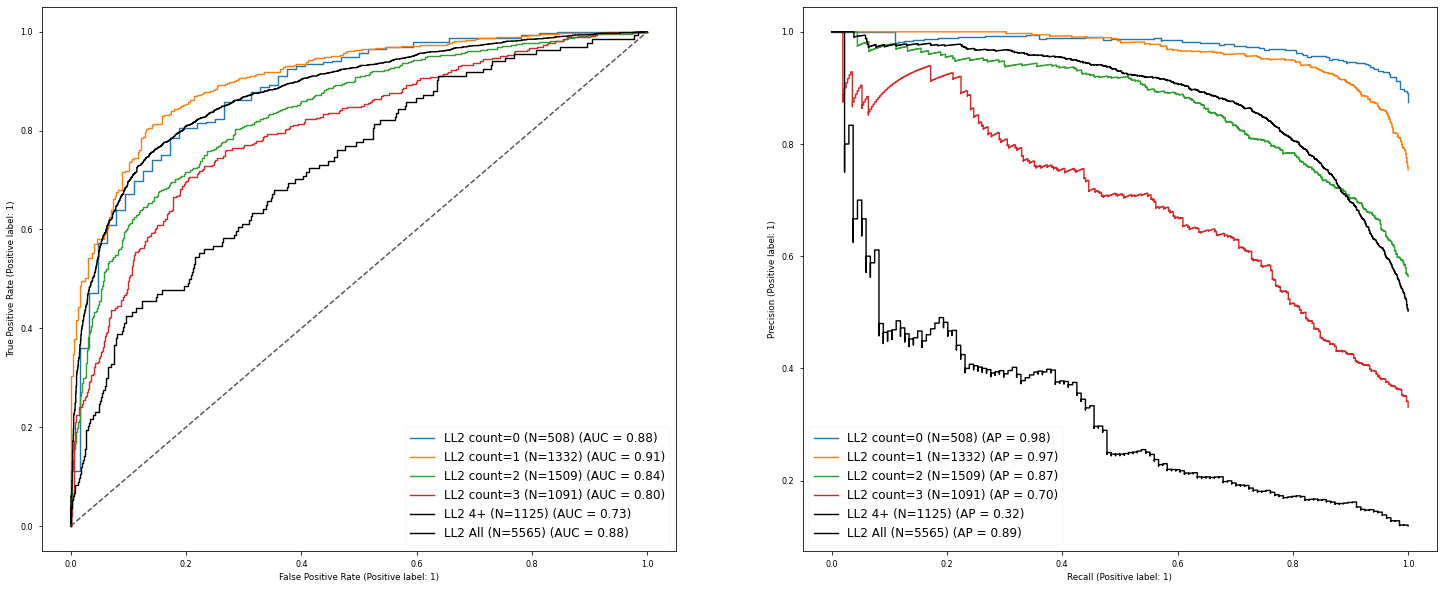

In [8]:

all_gt = []
all_pred = []
gt_4plus = []
pred_4plus = []
fig, ax = plt.subplots(1,2, figsize=(25,10))
for count in range(9):
    
    all_gt.append(result_binned[count]['gt_prob'])
    all_pred.append(result_binned[count]['pred_prob'])
    
    if count >=4:
        gt_4plus.append(result_binned[count]['gt_prob'])
        pred_4plus.append(result_binned[count]['pred_prob'])
        continue
    
    RocCurveDisplay.from_predictions(
        result_binned[count]['gt_prob'],
        result_binned[count]['pred_prob'],
        name='LL2 count=' + str(count) + ' (N=' + str(len(result_binned[count]['gt_prob'])) + ')',
        ax = ax[0],
    )
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.savefig('LL2_ROC.eps', format = 'eps')
    #plt.show()
    PrecisionRecallDisplay.from_predictions(
        result_binned[count]['gt_prob'],
        result_binned[count]['pred_prob'],
        name='LL2 count=' + str(count) + ' (N=' + str(len(result_binned[count]['gt_prob'])) + ')',
        ax=ax[1],
    )
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    #plt.savefig('LL2_PRC.eps', format = 'eps')

all_gt = np.concatenate(all_gt)    
all_pred = np.concatenate(all_pred)
gt_4plus = np.concatenate(gt_4plus)
pred_4plus = np.concatenate(pred_4plus)

RocCurveDisplay.from_predictions(
    gt_4plus,
    pred_4plus,
    name='LL2 4+ (N=' + str(len(gt_4plus)) + ')',
    ax = ax[0],
    color = 'black',
)
PrecisionRecallDisplay.from_predictions(
    gt_4plus,
    pred_4plus,
    name='LL2 4+ (N=' + str(len(gt_4plus)) + ')',
    ax=ax[1],
    color = 'black',
)


RocCurveDisplay.from_predictions(
    all_gt,
    all_pred,
    name='LL2 All (N=' + str(len(all_gt)) + ')',
    ax = ax[0],
    color = 'black',
)
PrecisionRecallDisplay.from_predictions(
    all_gt,
    all_pred,
    name='LL2 All (N=' + str(len(all_gt)) + ')',
    ax=ax[1],
    color = 'black',
)
ax[0].legend(fontsize="12")
ax[1].legend(fontsize="12")
ax[0].plot([0, 1], [0, 1], ls="--", c=".3")
plt.savefig('LL2_binned_results.eps', format = 'eps')
plt.show()